In this notebook I'll explore the transformation on sequence related features, aiming to add more accuracy to the prediction.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import sys
import os
sys.path.append(os.path.join(
    os.path.abspath(os.path.pardir), 'src'
))

In [2]:
import nzcompetition

Enter Windows password for user shya:········
User shya successfully authenticated


# Data

In [3]:
X_raw, y_train, _ = nzcompetition.get_raw_data(target=['performance', 'odor'])

In [4]:
X_raw, y_train = nzcompetition.drop_dup(X_raw, y_train)

transformer = nzcompetition.Transformer(use_seq_feature=False, use_org_feature=False)
X = transformer.fit_transform(X_raw)
X = pd.DataFrame(X, columns=transformer.df_columns_, index=transformer.df_index_)
y = y_train.reindex(X.index)
y.columns = ['performance', 'odor']

/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/numtransform.py:228: RuntimeWarning: Mean of empty slice
  df[newcol] = np.nanmean(df[origcols], axis=1)


Currently `X` is the transformed X (from numeric feature and categorical feature), with the sequence-duplicated record removed. And `y` is the corresponding outcomes (2 variables, `performance` and `odor`.

In [5]:
seq_columns = [
    'AA_Sequence', 
    'Mutations_on_Lipolase_Backbone',
    'Mutations_on_MML_Backbone', 
]
X_seq = X_raw[seq_columns].copy().reindex(X.index)

Now the `X_seq` is our input.

# Explore

In [6]:
X_seq.head(3)

AA_Sequence  \
Organism Code purifiedsample_sequoia_identifier                                                      
HL03790       U1NU1                              EVSQDLFNQFNLFAQYSAAAYCGKNNDAPAGTNITCTGNACPEVEK...   
HL03981       U864C                              EVSQDLFNQFNLFAQYSAAAYCGKNNDAPAGTNITCTGNACPEVEK...   
HL04098       U1PTF                              EVSQDLFNQFNLFAQYSAAAYCGKNNDAPAGTNITCTGNACPEVEK...   

                                                Mutations_on_Lipolase_Backbone  \
Organism Code purifiedsample_sequoia_identifier                                  
HL03790       U1NU1                                                       > 40   
HL03981       U864C                                                       None   
HL04098       U1PTF                                                       > 40   

                                                                         Mutations_on_MML_Backbone  
Organism Code purifiedsample_sequoia_identifier                                                     
HL03790       U1NU1                                                                           > 40  
HL03981       U864C                              D1E, A4Q, L7F, K11N, R24K, S37T, A38G, L43E, A...  
HL04098       U1PTF                                                                           > 40

### Missingness

In [7]:
X_seq[['Mutations_on_Lipolase_Backbone', 'Mutations_on_MML_Backbone']].isna().any(axis=1).value_counts()

False    119
True       3
dtype: int64

In [8]:
X_seq[X_seq[['Mutations_on_Lipolase_Backbone', 'Mutations_on_MML_Backbone']].isna().any(axis=1)]

AA_Sequence  \
Organism Code purifiedsample_sequoia_identifier                                                      
HL03981       U864C                              EVSQDLFNQFNLFAQYSAAAYCGKNNDAPAGTNITCTGNACPEVEK...   
HL04100       U1PTH                              EVSQDLFNQFNLFAQYSAAAYCGKNNDAPAGTNITCTGNACPEVEK...   
TLL43661      U2MPN                              DVSADLLNQFKLFAQYSAAAYCGRNNDAPAGTNITCSANACPLVEA...   

                                                                    Mutations_on_Lipolase_Backbone  \
Organism Code purifiedsample_sequoia_identifier                                                      
HL03981       U864C                                                                           None   
HL04100       U1PTH                                                                           None   
TLL43661      U2MPN                              E1D, Q4A, F7L, N11K, K24R, T37S, G38A, E43L, K...   

                                                                         Mutations_on_MML_Backbone  
Organism Code purifiedsample_sequoia_identifier                                                     
HL03981       U864C                              D1E, A4Q, L7F, K11N, R24K, S37T, A38G, L43E, A...  
HL04100       U1PTH                              D1E, A4Q, L7F, K11N, R24K, S37T, A38G, L43E, A...  
TLL43661      U2MPN                                                                           None

Here I guess that the missing means no such mutations.

### Sequence length

In [9]:
X_seq['AA_Sequence'].map(len).value_counts()

269    121
266      1
Name: AA_Sequence, dtype: int64

Only 2 sequence lengths, one 266AA, all others are 269 AA.

In [10]:
X_seq.loc[X_seq['AA_Sequence'].map(len)==266, :]

AA_Sequence  \
Organism Code purifiedsample_sequoia_identifier                                                      
TLL42537      U8AT5                              EVSQDLFNQFNLFAQYSAAAYCGKNNDAPAGTNITCTGNACPEVEK...   

                                                                    Mutations_on_Lipolase_Backbone  \
Organism Code purifiedsample_sequoia_identifier                                                      
TLL42537      U8AT5                              F51I, E56R, G91A, N92D, D96I, K98Q, R118F, S22...   

                                                Mutations_on_MML_Backbone  
Organism Code purifiedsample_sequoia_identifier                            
TLL42537      U8AT5                                                  > 40

In [11]:
X_seq.loc[X_seq['AA_Sequence'].map(len)==266, 'Mutations_on_Lipolase_Backbone'].tolist()

['F51I, E56R, G91A, N92D, D96I, K98Q, R118F, S224R, P229*, V230*, T231*, N233V, D234N, D254S, L264A']

In [12]:
X_seq.loc[
    (
        X_seq[['Mutations_on_Lipolase_Backbone', 'Mutations_on_MML_Backbone']]
        .applymap(lambda s: '*' in s if s else False).any(axis=1)
    ), 
    :
]

AA_Sequence  \
Organism Code purifiedsample_sequoia_identifier                                                      
TLL42537      U8AT5                              EVSQDLFNQFNLFAQYSAAAYCGKNNDAPAGTNITCTGNACPEVEK...   

                                                                    Mutations_on_Lipolase_Backbone  \
Organism Code purifiedsample_sequoia_identifier                                                      
TLL42537      U8AT5                              F51I, E56R, G91A, N92D, D96I, K98Q, R118F, S22...   

                                                Mutations_on_MML_Backbone  
Organism Code purifiedsample_sequoia_identifier                            
TLL42537      U8AT5                                                  > 40

No other mutation notes have `*`. Seems here the `*` in mutation represents deletion, unlike the common mutation format.

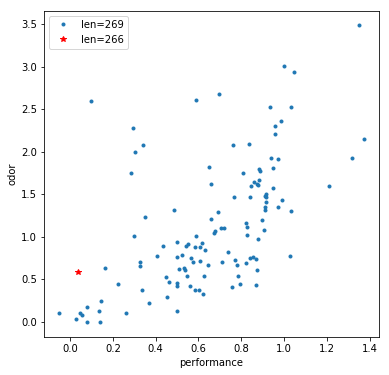

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(
    y.loc[X_seq['AA_Sequence'].map(len)==269, 'performance'], 
    y.loc[X_seq['AA_Sequence'].map(len)==269, 'odor'], 
    '.'
)
ax.plot(
    y.loc[X_seq['AA_Sequence'].map(len)==266, 'performance'], 
    y.loc[X_seq['AA_Sequence'].map(len)==266, 'odor'], 
    'r*'
)
ax.legend(['len=269', 'len=266'])
ax.set_xlabel('performance')
ax.set_ylabel('odor')
fig.show()

Seems nothing suspicious for length.

### Mutations

There are 2 kind of mutations: on lipolase backbone and on MML backbone.

#### Incorrect mutation marks

Let's take the `('HL03981', 'U864C')` record as an example.

In [14]:
muts = X_seq.loc[('HL03981', 'U864C'), 'Mutations_on_MML_Backbone']

mutseq = X_seq.loc[('HL03981', 'U864C'), 'AA_Sequence']

for mut in muts.split(', '):
    orgAA, pos, mutAA = mut[0], int(mut[1:-1]), mut[-1]
    if mutseq[pos-1] != mutAA:
        print('incorrect mutation annotation {}'.format(mut))
        print('Original: {}, on mut seq: {}'.format(orgAA, mutseq[pos-1]))

incorrect mutation annotation Q210E
Original: Q, on mut seq: A
incorrect mutation annotation R231T
Original: R, on mut seq: R
incorrect mutation annotation R233N
Original: R, on mut seq: R


We need to remove incorrect mutation marks, either correct the mutation mark by AA sequence, or ignore them if no mutation on the sequence.

#### Backbone sequence

Question: does the backbone sequence identical?

In [15]:
# try reconstruct the backbone
def restore_seq(seq, muts):
    """restore the sequence before mutations.
    Arguments:
        seq: str, AA sequence after mutation
        muts: str, string denoting mutations, comma separated, '*' means deletion.
    Returns:
        origseq: str, original sequence before mutation.
    """
    if not isinstance(muts, str):
        return seq
    if muts.startswith(">"):
        return None
    origseq = seq
    mutlst = muts.strip().split(', ')
    mutlst.sort(key=lambda s: int(s[1:-1]))
    for mut in mutlst:
        seq = restore_one_mut(seq, mut)
    return seq

def restore_one_mut(mutseq, mut):
    """restore the sequence before the provided mutation
    Arguments:
        mutseq: str, AA sequence after mutation
        mut: str, 1 AA mutation on original sequence, '*' means deletion
    Returns:
        origseq: str, original sequence before mutation
    """
    orgAA, pos, mutAA = mut[0], int(mut[1:-1]), mut[-1]
    if mutAA != '*':
        try:
            assert mutseq[pos-1] == mutAA
        except AssertionError:
            # Since I haven't cleared the wrong mutations, just ignore them
            pass
        newseq = ''.join([
            mutseq[:pos-1], orgAA, mutseq[pos:]
        ])
        return newseq
    else:
        newseq = ''.join([
            mutseq[:pos-1], orgAA, mutseq[pos-1:]
        ])
        return newseq
    

In [16]:
X_seq['lipolase_backbone'] = X_seq[['AA_Sequence', 'Mutations_on_Lipolase_Backbone']].apply(lambda s: restore_seq(*s), axis=1)

In [17]:
X_seq['MML_backbone'] = X_seq[['AA_Sequence', 'Mutations_on_MML_Backbone']].apply(lambda s: restore_seq(*s), axis=1)

In [18]:
X_seq['lipolase_backbone'].value_counts()

EVSQDLFNQFNLFAQYSAAAYCGKNNDAPAGTNITCTGNACPEVEKADATFLYSFEDSGVGDVTGFLALDNTNKLIVLSFRGSRSIENWIGNLNFDLKEINDICSGCRGHDGFTSSWRSVADTLRQKVEDAVREHPDYRVVFTGHSLGGALATVAGADLRGNGYDIDVFSYGAPRVGNRAFAEFLTVQTGGTLYRITHTNDIVPRLPPREFGYSHSSPEYWIKSGTLVPVTRNDIVKIEGIDATGGNNQPNIPDIPAHLWYFGLIGTCL    113
EVSQDLFNQFNLFAQYSAAAYCGKNNDAPAGTNITCTGNACPEVEKADATFLYSFEDTGKGDVTGFLALDNTNKLIVLSFRGSRSIENWIGNLNFDLKEINDICSGCRGHDGFTSSWRSVADTLRQKVEDAVREHPDYRVVFTGHSLGGGLATVAGADLRGNGYDIDVFSYGAPRVGNRAFAEFLTVQTGGTLYRITHTNDIVPRLPPRAFGYSHSSPEYWIKSGTLVPVRRRDIVKIEGIDATGGNNQPNIPDIPAHLWYFGLIGTCL      1
EVSQDLFNQFNLFAQYSAAAYCGKNNDAPAGTNITCTGNACPEVEKADATFLYSFEDSGVGDVTGFLALDNTNKLIVLSFRGSRSIENWIGNLNFDLKEINDICSGCRGHDGFTSSWRSVADTLRQKVEDAVREHPDYRVVFTGHSLGGALATVAGADLRGNGYDIDVFSYGAPRVGNRAFAEFLTVQTGGTLYRITHTNDLVPRLPPRQFGYSHSSPEYWIKSGTLVPVRRRDIVKIEGIDATGGNNQPNIPDAKAHLWYFGLIGTCL      1
Name: lipolase_backbone, dtype: int64

In [19]:
X_seq.drop_duplicates(subset='lipolase_backbone', keep=False).loc[:, ['Mutations_on_Lipolase_Backbone']]

Mutations_on_Lipolase_Backbone
Organism Code purifiedsample_sequoia_identifier                               
HL03981       U864C                                                       None
HL04100       U1PTH                                                       None

In [20]:
X_seq['MML_backbone'].value_counts()

DVSADLLNQFKLFAQYSAAAYCGRNNDAPAGTNITCSANACPLVEAADATFLYSFENSGVGDVTGFLAVDNTNKLIVLSFRGSRSIENWITNLNFDLVDINDICSGCRGHDGFTSSWRSVADTLRQAVDDAVAAHPDYKVVVTGHSLGGALATLAGADLRNNGYDVDLYTYGAPRVGNRAFAEFITVQTGGTLYRVTHTNDVVPRLPPRQFGYSHPSPEYWIKSGTLVPVRRRDIVKIEGIDATGGNNQNNTPDIPAHLWYFGLIGTCI    112
DVSADLLNQFKLFAQYSAAAYCGRNNDAPAGTNITCSANACPLVEAADATFLYSFENSGVGDVTGFLAVDNTNKLIVLSFRGSRSIENWITNLNFDLVDINDICSGCRGHDGFTSSWRSVADTLRQAVDDAVAAHPDYKVVVTGHSLGGALATLAGADLRNNGYDVDLYTYGAPRVGNRAFAEFITVQTGGTLYRVTHTNDVVPRLPPRQFGYSHPSPEYWIKSGTLVPVRRRDIVKIEGIDATGGNNQNNTPDAKAHLWYFGLIGTCI      1
DVSADLLNQFKLFAQYSAAAYCGRNNDAPAGTNITCSANACPLVEAADATFLYSFENTGKGDVTGFLAVDNTNKLIVLSFRGSRSIENWITNLNFDLVDINDICSGCRGHDGFTSSWRSVADTLRQAVDDAVAAHPDYKVVVTGHSLGGGLATLAGADLRNNGYDVDLYTYGAPRVGNRAFAEFITVQTGGTLYRVTHTNDVVPRLPPRQFGYSHPSPEYWIKSGTLVPVRRRDIVKIEGIDATGGNNQNNTPDIPAHLWYFGLIGTCI      1
Name: MML_backbone, dtype: int64

In [21]:
X_seq.drop_duplicates(subset='MML_backbone', keep=False).loc[:, ['Mutations_on_MML_Backbone']]

Mutations_on_MML_Backbone
Organism Code purifiedsample_sequoia_identifier                                                   
HL03981       U864C                              D1E, A4Q, L7F, K11N, R24K, S37T, A38G, L43E, A...
HL04100       U1PTH                              D1E, A4Q, L7F, K11N, R24K, S37T, A38G, L43E, A...

We need to re-calculate the mutations for the 2 records, using the correct backbone. Note that for testing set we also need to perform such transformation.

In [22]:
lipolase_backbone = (
    'EVSQDLFNQFNLFAQYSAAAYCGKNNDAPAGTNITCTGNACPEVEKADATFLYSFEDSGVGDVT'
    'GFLALDNTNKLIVLSFRGSRSIENWIGNLNFDLKEINDICSGCRGHDGFTSSWRSVADTLRQKV'
    'EDAVREHPDYRVVFTGHSLGGALATVAGADLRGNGYDIDVFSYGAPRVGNRAFAEFLTVQTGGT'
    'LYRITHTNDIVPRLPPREFGYSHSSPEYWIKSGTLVPVTRNDIVKIEGIDATGGNNQPNIPDIP'
    'AHLWYFGLIGTCL'
)

mml_backbone = (
    'DVSADLLNQFKLFAQYSAAAYCGRNNDAPAGTNITCSANACPLVEAADATFLYSFENSGVGDVT'
    'GFLAVDNTNKLIVLSFRGSRSIENWITNLNFDLVDINDICSGCRGHDGFTSSWRSVADTLRQAV'
    'DDAVAAHPDYKVVVTGHSLGGALATLAGADLRNNGYDVDLYTYGAPRVGNRAFAEFITVQTGGT'
    'LYRVTHTNDVVPRLPPRQFGYSHPSPEYWIKSGTLVPVRRRDIVKIEGIDATGGNNQNNTPDIP'
    'AHLWYFGLIGTCI'
)

In [23]:
def list_mutation(seq, backbone):
    """list the mutations by referencing with the backbone.
    Arguments:
        seq: str, mutated sequence, length as backbone or 3 shorter at 229-231 (1based)
        backbone: str, original sequence
    Returns:
        muts: str, comma separated mutations (miss-sense only)
    """
    if len(seq) != len(backbone):
        seq = seq[:228]+'***'+seq[228:]
    mutlst = []
    for i in range(len(seq)):
        aa = seq[i]
        bkbaa = backbone[i]
        if aa != bkbaa:
            mut = '{}{}{}'.format(bkbaa, i+1, aa)
            mutlst.append(mut)
    if mutlst:
        return ", ".join(mutlst)
    else:
        return None

What's the differences between the 2 backbones?

In [24]:
list_mutation(lipolase_backbone, mml_backbone)

'D1E, A4Q, L7F, K11N, R24K, S37T, A38G, L43E, A46K, N57D, V69L, T91G, V98K, D99E, A127K, D129E, A133R, A134E, K139R, V142F, L154V, N161G, V166I, L168V, Y169F, T170S, I185L, V196I, V202I, Q210E, P216S, R231T, R233N, N250P, T252I, I269L'

Now let's recalculate the mutations from unified backbone.

In [25]:
X_seq.loc[
    X_seq['lipolase_backbone']!=lipolase_backbone, 
    'Mutations_on_Lipolase_Backbone'
] = [
    list_mutation(seq, lipolase_backbone) for seq in X_seq.loc[
        X_seq['lipolase_backbone']!=lipolase_backbone, 
        'AA_Sequence'
    ]
]

X_seq.loc[
    X_seq['MML_backbone']!=mml_backbone, 
    'Mutations_on_MML_Backbone'
] = [
    list_mutation(seq, lipolase_backbone) for seq in X_seq.loc[
        X_seq['MML_backbone']!=mml_backbone, 
        'AA_Sequence'
    ]
]

In [26]:
X_seq['Mutations_on_Lipolase_Backbone'] = [
    list_mutation(seq, lipolase_backbone) 
    for seq in X_seq['AA_Sequence']
]

X_seq['Mutations_on_MML_Backbone'] = [
    list_mutation(seq, mml_backbone) 
    for seq in X_seq['AA_Sequence']
]

X_seq = X_seq.rename(columns={
    'Mutations_on_MML_Backbone': 'muts_on_mml', 
    'Mutations_on_Lipolase_Backbone': 'muts_on_lipolase'
})

In [27]:
# now we don't need the calculated backbones
X_seq = X_seq.drop(columns=[
    'lipolase_backbone', 'MML_backbone'
])

In [28]:
X_seq.columns

Index(['AA_Sequence', 'muts_on_lipolase', 'muts_on_mml'], dtype='object')

Now we have the correct mutation lists for 2 backbones. Let's explore them.

### Mutation count

In [29]:
X_seq['muts_count_on_lipolase'] = (
    X_seq.muts_on_lipolase
    .apply(lambda s: len(s.split(', ')) if s else 0)
)

X_seq['muts_count_on_mml'] = (
    X_seq.muts_on_mml
    .apply(lambda s: len(s.split(', ')) if s else 0)
)

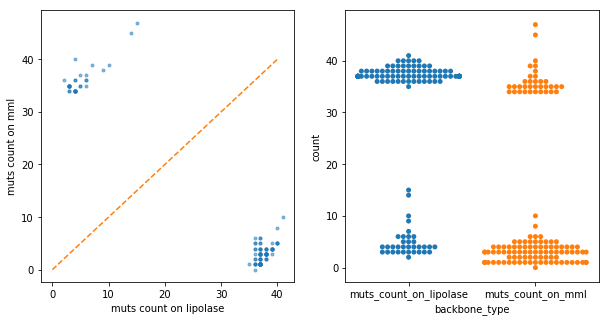

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(X_seq.muts_count_on_lipolase, X_seq.muts_count_on_mml, '.', alpha=0.5)
axs[0].set_xlabel('muts count on lipolase')
axs[0].set_ylabel('muts count on mml')
axs[0].plot([0, 40], [0, 40], '--')

#axs[1].boxplot(
#    x=X_seq[['muts_count_on_lipolase', 'muts_count_on_mml']].T, 
#    labels=['muts count on lipolase', 'muts count on mml'])

axs[1] = sns.swarmplot(
    x='backbone_type', 
    y='count', 
    data=(
        X_seq[['muts_count_on_lipolase', 'muts_count_on_mml']]
        .melt(value_name='count', var_name='backbone_type')
    )
)

fig.show()

From the figure above we can see there are roughly 2 groups of samples: high mut on lipolase, high mut on mml. Now we can explore if the mutation has something to do with predicting outcomes.

### Mutation distribution

Here Let's identify mutation hot spots on the backbones.

In [31]:
len_backbone = len(lipolase_backbone)

def count_mut_dist(muts_count_ser):
    "count the distribution of mutations from a pandas.Series of comma joint mutations"
    mutdf = pd.DataFrame(
        np.zeros((len_backbone, 2)), 
        index=np.arange(1, len_backbone+1), 
        columns=['mutCount', 'mutAA'], 
    )
    mutdf.mutAA = ''
    mutdf['mutCount'] = mutdf['mutCount'].astype(np.int32)
    for muts in muts_count_ser:
        if muts is None:
            continue
        for mut in muts.split(', '):
            orgAA, pos, mutAA = mut[0], int(mut[1:-1]), mut[-1]
            mutdf.loc[pos, 'mutCount'] += 1
            mutdf.loc[pos, 'mutAA'] += mutAA
    return mutdf
    

In [32]:
lipo_mut_dist = count_mut_dist(X_seq.muts_on_lipolase)
mml_mut_dist = count_mut_dist(X_seq.muts_on_mml)

In [33]:
backbone_diff_poses = [
    int(mut[1:-1]) 
    for mut in list_mutation(lipolase_backbone, mml_backbone).split(', ')
]

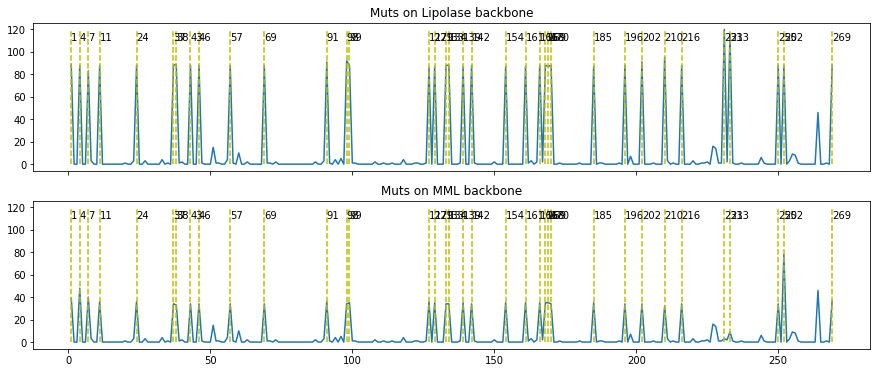

In [34]:
fig, axs = plt.subplots(2, 1, figsize=(15, 6), sharex=True, sharey=True)

axs[0].plot(lipo_mut_dist.index, lipo_mut_dist.mutCount, '-')
axs[0].set_title('Muts on Lipolase backbone')

axs[1].plot(mml_mut_dist.index, mml_mut_dist.mutCount, '-')
axs[1].set_title('Muts on MML backbone')

# plot the differences of backbones
for ax in axs:
    for pos in backbone_diff_poses:
        ax.plot([pos, pos], [0, 120], 'y--')
        ax.text(pos, 110, str(pos))

fig.show()

Nearly all the peaks come from where 2 backbones differes, which coincides with the mutation count plot, and indicates that the sequences originated from 1 of the backbones. Thus we might split originates and subtract the mutation list.

Before grouping sequences, let's see if the mutations on backbone diff sites all come from backbone differences.

In [35]:
pd.concat((mml_mut_dist, lipo_mut_dist), axis=1).reindex(backbone_diff_poses)

mutCount                                              mutAA  mutCount  \
1          39            EEEEEEEQGQFHEEEEEEEEECEEEEEEEEEEEEEEEEE        89   
4          48   QQQQQQQERKRRRRRQLSQRRQQQQQQQQQQQQQQQQQRQQQQQQQQR        88   
7          40           FFFFFFFFYFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF        83   
11         36               NNNNNNNNNNNNNNNNNNNNNNNNNNNRNNQNNNNN        88   
24         36               KKKKKKKKKKKKKKKKKKKKKKKKKKKKKEEKKKKK        88   
37         34                 TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT        88   
38         33                  GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG        89   
43         34                 EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE        88   
46         34                 KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK        88   
57         34                 DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD        88   
69         34                 LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL        88   
91         36               GGGGGGGAAAGGAGGGGAGGGGGGGGGGGGGGGGGG        91   
98         34                 KKKKKKKKKKKKKQIEIKKKKKKKKKKKKKKKKK        92   
99         35                EEEEEEEELEEEEEEEEEEEEEEEEEEEEEEEEEE        88   
127        36               KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK        86   
129        35                EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE        87   
133        34                 RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR        88   
134        34                 EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE        88   
139        35                RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR        87   
142        34                 FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF        88   
154        35                VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV        87   
161        35                GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG        87   
166        35                IIIIIIIICIIIIIIIIIIIIIIIIIIIIIIIIII        88   
168        35                VVVVVVVVRVVVVVVVVVVVVVVVVVVVVVVVVVV        88   
169        35                FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF        87   
170        34                 SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS        88   
185        35                LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL        87   
196        34                 IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII        88   
202        34                 IILLLIIIIIIIIIIIIIIIIIIIIIIIIIIIII        91   
210        32                   VARTGEEEEEEEEEEEEEEEEEEEEEEEEEEE        95   
216        34                 SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS        88   
231         3                                                T*T       120   
233         9                                          NNNNVCNKN       116   
250        34                 PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP        88   
252        78  IIIIIIIAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAIAAIII...        88   
269        37              LLLLLLLFWLLLLLLLLLLLLLLLLLLLLLLVLLLLL        88   

                                                 mutAA  
1    DDDQDDDDGDDDDDDDDDDDDDDDDDDDDQDDDDDDDDDDDDDDDF...  
4    AAAAAAAAAAAAAAAAAAAAAAAEAAAARAKRRAAAAAAARRRAAA...  
7    LLLLLLLLLLLLLLLLLLLLLLLYLLLLLLLLLLLLLLLLLLLLLL...  
11   KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK...  
24   RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR...  
37   SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...  
38   AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...  
43   LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL...  
46   AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...  
57   NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...  
69   VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV...  
91   TTTTTTTATTTTTTTTTTTTTTTTTTTTTTTTTTAATTTTTTTTTT...  
98   VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV...  
99   DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...  
127  AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...  
129  DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...  
133  AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...  
134  AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...  
139  KKKKKKKKKKKKKKKKKKKKKKKKKKKKKK

Although the majority come from backbone differences, there are still several designed mutations.

Next: classify sequences by backbone similarity; recount mutations (try mimicing the design)

### Classify origins

This way we can create new features: `is_from_lipolase` & `is_from_mml`. Then we can calculate mutatoin features for each class.

In [36]:
X_seq['is_from_lipolase'] = X_seq['muts_count_on_lipolase'] < X_seq['muts_count_on_mml']
X_seq['is_from_mml'] = X_seq['muts_count_on_lipolase'] > X_seq['muts_count_on_mml']

Now we can reorg the mutations based on origins.

In [37]:
X_seq['muts_on_backbone'] = pd.concat([
    X_seq.loc[X_seq.is_from_lipolase, 'muts_on_lipolase'], 
    X_seq.loc[X_seq.is_from_mml, 'muts_on_mml'], 
])
X_seq['muts_count_on_backbone'] = (
    X_seq['muts_on_backbone']
    .apply(lambda s: len(s.split(', ')) if s else 0)
)

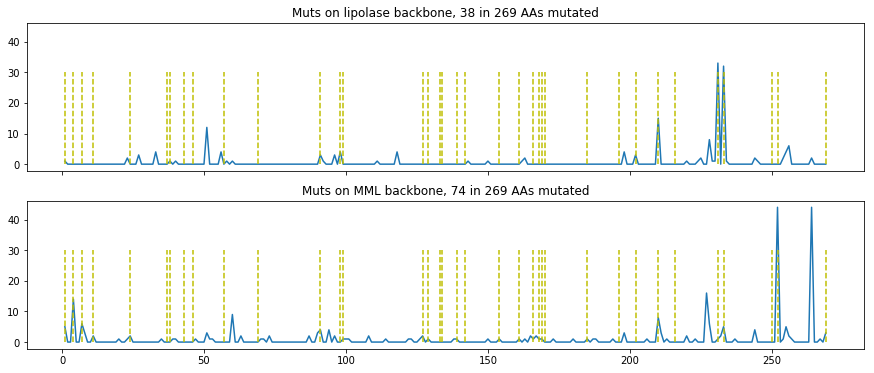

In [38]:
mutdist_lip = count_mut_dist(X_seq.loc[X_seq.is_from_lipolase, 'muts_on_backbone'])
mutdist_mml = count_mut_dist(X_seq.loc[X_seq.is_from_mml, 'muts_on_backbone'])

fig, axs = plt.subplots(2, 1, figsize=(15, 6), sharex=True, sharey=True)

for i, (df, name) in enumerate(zip(
    [mutdist_lip, mutdist_mml], 
    ['lipolase', 'MML']
)):
    axs[i].plot(df.index, df.mutCount, '-')
    axs[i].set_title('Muts on {} backbone, {} in 269 AAs mutated'.format(
        name, sum(df.mutCount>0)
    ))
    for pos in backbone_diff_poses:
        axs[i].plot([pos, pos], [0, 30], 'y--')

fig.show()

Now we know the basic landscape of directed mutations in this project.

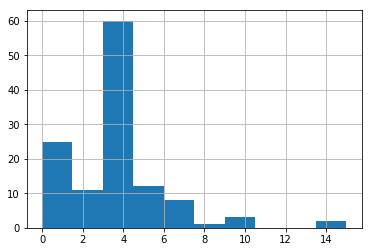

In [39]:
X_seq.muts_count_on_backbone.hist()

Now we can wrap the codes. Next time I'll explore sequence related features from Green/Sequoia.

# Examine benefits for prediction

This part will be constantly refreshed everytime a new feature is generated, just for inspecting prediction results with sequence related features.

## Plot correlations

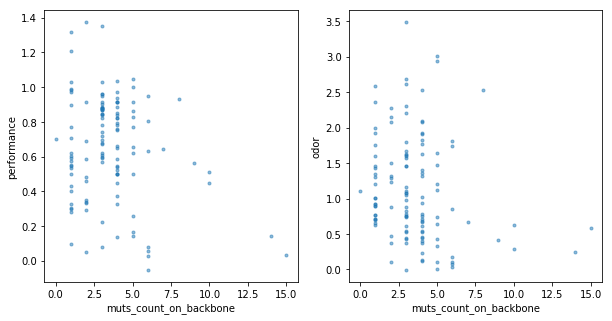

In [41]:
# plot y distribution according to mutation counts
fig, axs = plt.subplots(1, 2, figsize=(10,5))

for i, ycol in enumerate(['performance', 'odor']):
    axs[i].plot(X_seq['muts_count_on_backbone'], y[ycol], '.', alpha=0.5)
    axs[i].set_xlabel('muts_count_on_backbone')
    axs[i].set_ylabel(ycol)

fig.show()

### Check feature improvements on prediction

Now we have `X` as the transformed input (only numeric and categorical features) and `y` the corresponding outcomes (2 variables). We need to find out whether adding sequence related features can help prediction. 

Use LinearyRegression/LASSO/Ridge as the example model. Before calling the model we need to reduce the dimension as there are many highly correlated features.

In [42]:
from nzcompetition.metrics import cv_preds_metrics
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [43]:
def corr(y, yhat):
    return np.corrcoef(y, yhat)[0,1]

def diff_variance(y, yhat):
    return np.var(y-yhat)

In [44]:
X_pca = PCA(0.95).fit_transform(X)
X_plus_seq_pca = (
    PCA(0.95)
    .fit_transform(
        StandardScaler()
        .fit_transform(
            np.c_[
                X, 
                X_seq[
                    ['is_from_lipolase', 'is_from_mml', 'muts_count_on_backbone']
                ].astype(np.float64)
            ]
        )
    )
)

In [45]:
metdf = pd.concat([
    cv_preds_metrics(
        Ridge(alpha=1), 
#        LinearRegression(n_jobs=8), 
        metrics=[mean_squared_error, corr, diff_variance], 
        cv=[3, 5, 10, 20], 
        X=X_pca, 
        y=y.performance
    ), 
    cv_preds_metrics(
        Ridge(alpha=1), 
#        LinearRegression(n_jobs=8), 
        metrics=[mean_squared_error, corr, diff_variance], 
        cv=[3, 5, 10, 20], 
        X=X_plus_seq_pca, 
        y=y.performance
    ), 
], ignore_index=False)

metdf.index = [['without_seq_features']*4+['with_seq_features']*4, metdf.index]
metdf

mean_squared_error      corr  diff_variance
without_seq_features 3             0.020118  0.879785       0.020083
                     5             0.022116  0.869027       0.021765
                     10            0.022351  0.867383       0.022322
                     20            0.021839  0.869991       0.021839
with_seq_features    3             0.038164  0.779364       0.037857
                     5             0.028295  0.829665       0.028081
                     10            0.028609  0.829242       0.028580
                     20            0.028055  0.831180       0.028049

In [46]:
metdf = pd.concat([
    cv_preds_metrics(
        Ridge(alpha=1), 
#        LinearRegression(n_jobs=8), 
        metrics=[mean_squared_error, corr, diff_variance], 
        cv=[3, 5, 10, 20], 
        X=X_pca, 
        y=y.odor
    ), 
    cv_preds_metrics(
        Ridge(alpha=1), 
#        LinearRegression(n_jobs=8), 
        metrics=[mean_squared_error, corr, diff_variance], 
        cv=[3, 5, 10, 20], 
        X=X_plus_seq_pca, 
        y=y.odor
    ), 
], ignore_index=False)

metdf.index = [['without_seq_features']*4+['with_seq_features']*4, metdf.index]
metdf

mean_squared_error      corr  diff_variance
without_seq_features 3             0.791620  0.293706       0.788956
                     5             0.636651  0.367529       0.636646
                     10            0.555251  0.414721       0.555210
                     20            0.431114  0.521956       0.430956
with_seq_features    3             0.693010  0.372318       0.684291
                     5             0.550550  0.501695       0.549497
                     10            0.540564  0.491409       0.538786
                     20            0.395143  0.583627       0.394676

Worse in predicting performance but better in odor?

# Transformation rational

The goal of transformation is: feature engineering for more informative features for prediction.

1. recalculate backbone
1. fix mutation list by correct backbone
1. count mutations (splitting mutation count from mutation list)
1. drop original mutation columns

Then validate if the added features helped prediction.

Further questions:
* What's the secondary structure and functional domains of the backbones?
* What's the relationship of the 2 backbones?
* How many mutations are there? 
* Is there any hot spots?
* What's the grouping of mutations, is there any classification?
* Which mutation or mutation groups correlates with outcomes?
* What will a multiple alignment reveal?

Also we can use the index to search Green for domain information.

Seq features:
* muts_count_on_lipolase
* muts_count_on_mml